In [1]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

import re,string
import tarfile
import codecs
import numpy as np 
import pandas as pd
from textacy import preprocessing
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import altair as alt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from collections import Counter
from wordcloud import WordCloud


In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')

# Reading log file

In [26]:
log_data  = open('../data/BGL.log', 'r')
split_list = []

for line in log_data:
    thing1 = line.split(' ')
    if thing1[0] == '-':
        label = 'Normal'
    else:
        label = 'Anomaly'
    id = thing1[1]
    time = thing1[2]
    unknown1 = thing1[3]
    exact_time = thing1[4]
    unknown2 = thing1[5]
    info = thing1[6:]
    split_list.append([id, time, unknown1, exact_time, unknown2, info, label])

df = pd.DataFrame(split_list, columns=['id', 'time', 'unknown1', 'exact_time', 'unknown2', 'info', 'label'])


# Data wrangling

In [27]:
# convert info from list to string
df['info'] = df['info'].apply(lambda x: ' '.join(x).replace('\n',"")).replace('|','')

In [28]:
def process_data(text):
    # convert to lowercase
    text = text.lower()
    # remove mlp such as FF:F2:9F:15:7E:DF:00:0D:60:EA:81:20
    text = re.sub(r'..\:..\:..\:..\:..\:..\:..\:..\:..\:..\:..\:..', '', text)
    
    # replace numbers
    text = re.sub(r"[^a-z ]", " ", text)
    # remove punctuation 
    text = preprocessing.remove.punctuation(text)
    # remove single word characters in text for ip adress 
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # normalize whitespace
    text = re.sub( '\s+', ' ', text)
    # remove stopwords
    # stopwords such like 'to', 'on', 'of', 'for'...
    stop_words = set(stopwords.words('english'))
    additional_words = ['mon','tue','wed', 'thu', 'fri', 'sat', 'sun',
                       'san', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
                        'aug', 'sep', 'oct', 'nov', 'dec', 'pdt'] # date time in text
    for i in additional_words:
        stop_words.add(i)
    word_tokens = word_tokenize(text) 

    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    text = ' '.join([w for w in filtered_sentence])
    
    
    return(text)

# print(df['info'][3520647])
# print(process_data(df['info'][3520647]))

cleaned_info = []
for i in df['info']:
    cleaned_info.append(process_data(i))
df['info'] = cleaned_info

In [29]:
df.head()

,id,time,unknown1,exact_time,unknown2,info,label
0,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,ras kernel info instruction cache parity error...,Normal
1,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,ras kernel info instruction cache parity error...,Normal
2,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,ras kernel info instruction cache parity error...,Normal
3,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,ras kernel info instruction cache parity error...,Normal
4,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,ras kernel info instruction cache parity error...,Normal


In [30]:
df.to_csv('../data/BGL_cleaned.csv',index=None)

In [42]:
df['label'].value_counts()

Normal     4399503
Anomaly     348460
Name: label, dtype: int64

In [35]:
df = pd.read_csv('../data/BGL_cleaned.csv')

In [25]:
df.isnull().sum()/len(df)

id            0.000000
time          0.000000
unknown1      0.018807
exact_time    0.000000
unknown2      0.018807
info          0.000000
label         0.000000
dtype: float64

In [43]:
counter = 0
anomaly_counter = 0
for i in range(0,len(df)-1):
    if ('fatal' in df['info'][i] and df['label'][i] == 'Anomaly'):
        counter +=1
    if (df['label'][i] == 'Anomaly'):
        anomaly_counter +=1
print(counter,anomaly_counter)

348397 348459


In [26]:
df_5per = df.sample(frac = 0.05)

In [27]:
# cv=CountVectorizer(stop_words='english')
# data_cv=cv.fit_transform(df_5per['info'])
# data=pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())


In [28]:
anomaly = df_5per[df_5per['label'] == 'Anomaly']
normal = df_5per[df_5per['label'] == 'Normal']

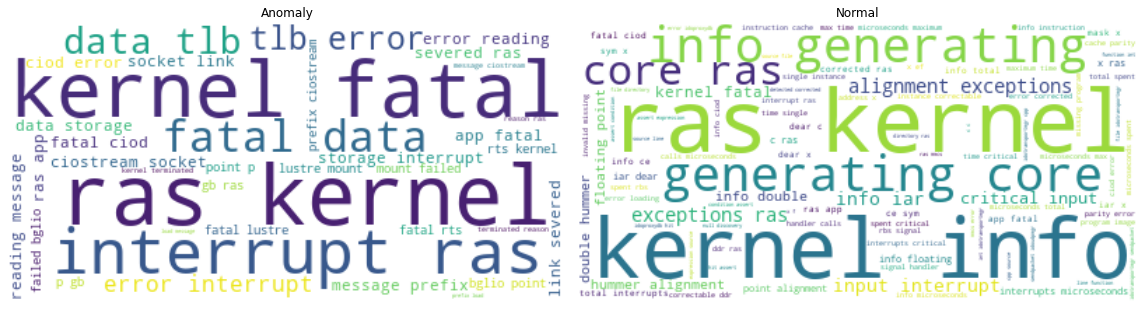

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,15))
text = " ".join(str(i) for i in anomaly['info'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Anomaly")

text = " ".join(str(i) for i in normal['info'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Normal")
fig.tight_layout()